In [144]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from matplotlib import ticker

In [2]:
# load the data
DF = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [3]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5291, 11)


,Energy,Consumer Discretionary,Financials,Industrials,Utilities,Consumer Staples,Real Estate,Communication Services,Materials,Information Technology,Health Care
Date,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-15.162661,0.946475,-18.817386,-21.914887,-13.140806,-4.858706,-0.294245,-0.863861,3.303588,-14.597120,-12.149445
2012-12-26,-9.763909,-22.927124,-19.146464,-32.016238,-30.861994,-24.124430,-10.870392,-3.661413,-3.646271,-27.670765,-34.542872
2012-12-27,-2.798086,10.674023,-21.539939,-11.556934,-4.524981,1.880229,1.640416,-2.525184,-10.469251,-7.213248,-0.922065


In [4]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(11, 11)
55.0
(1, 121) 55
1


(5251, 55)

In [5]:
# Repeated KMeans into 2 clusters

In [6]:
kmean = KMeans(n_clusters = 2,random_state = 12345).fit(CorrMatrices) 


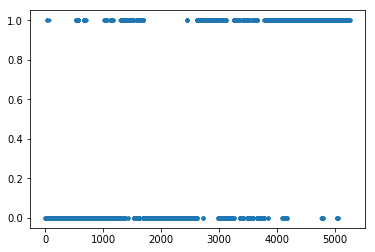

In [7]:
ypred = kmean.predict(CorrMatrices)

plt.plot(ypred,".")

In [8]:
#  now split the initial clusters

CMS0 = CorrMatrices[ypred ==0,:]
CMS1 = CorrMatrices[ypred ==1,:]
print(CMS0.shape,CMS1.shape)

(2739, 55) (2512, 55)


In [9]:
kmean0 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS0) 
ypred0 = kmean0.predict(CMS0)

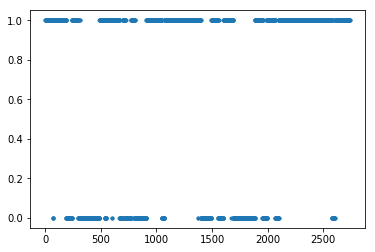

In [10]:
plt.plot(ypred0,".")

In [11]:
#  now split the these sub-clusters
CMS00 = CMS0[ypred0==0,:]
CMS01 = CMS0[ypred0==1,:]
print(CMS00.shape,CMS01.shape)

(907, 55) (1832, 55)


In [12]:
kmean00 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS00) 
ypred00 = kmean00.predict(CMS00)

In [13]:
kmean01 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS01) 
ypred01 = kmean01.predict(CMS01)

In [14]:
# final splits for the first initial cluster
CMS000 = CMS00[ypred00==0,:]
CMS001 = CMS00[ypred00==1,:]
CMS010 = CMS01[ypred01==0,:]
CMS011 = CMS01[ypred01==1,:]
print(CMS000.shape,
     CMS001.shape,
     CMS010.shape,
     CMS011.shape)

(660, 55) (247, 55) (939, 55) (893, 55)


In [15]:
# Now for the second initial cluster

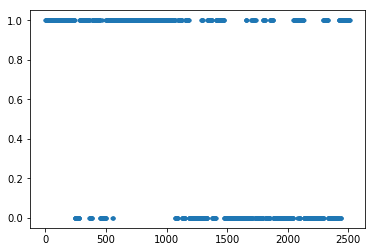

In [16]:
kmean1 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS1) 
ypred1 = kmean1.predict(CMS1)
plt.plot(ypred1,".")

In [17]:
#  now split the these sub-clusters
CMS10 = CMS1[ypred1==0,:]
CMS11 = CMS1[ypred1==1,:]
print(CMS10.shape,CMS11.shape)

(1097, 55) (1415, 55)


In [18]:
kmean10 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS10) 
ypred10 = kmean10.predict(CMS10)
kmean11 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS11) 
ypred11 = kmean11.predict(CMS11)

In [19]:
# final splits for the first initial cluster
CMS100 = CMS10[ypred10==0,:]
CMS101 = CMS10[ypred10==1,:]
CMS110 = CMS11[ypred11==0,:]
CMS111 = CMS11[ypred11==1,:]
print(CMS100.shape,
     CMS101.shape,
     CMS10.shape,
     CMS111.shape)

(759, 55) (338, 55) (1097, 55) (421, 55)


In [20]:
Labels = np.zeros(CorrMatrices.shape[0])

In [21]:
Lab = Labels[0:10]
print(Lab)
Lab  = np.arange(10)
print(Lab)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9]


In [22]:
print(Labels[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
def Label(Instance):
    
    
    Label1 = kmean.predict(Instance.reshape(1, -1))

    if Label1 == 0:
    
        Label2 = kmean0.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean00.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean01.predict(Instance.reshape(1,-1))
    
    
    elif Label1 == 1:
    
        Label2 = kmean1.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean10.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean11.predict(Instance.reshape(1,-1))
    return(str(Label1[0])+str(Label2[0])+str(Label3[0]))
            

In [24]:
Labels = []
for i in range(CorrMatrices.shape[0]):
    Labels.append(Label(CorrMatrices[i,:]))

In [25]:
sum(np.array(Labels)== '101')

338

In [26]:
Labels = np.array(Labels)

In [27]:
Labels[Labels=="000"] = 0
Labels[Labels=="001"] = 1
Labels[Labels=="010"] = 2
Labels[Labels=="011"] = 3
Labels[Labels=="100"] = 4
Labels[Labels=="101"] = 5
Labels[Labels=="110"] = 6
Labels[Labels=="111"] = 7
Labels = Labels.astype(np.int)

/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [28]:
TimeIndex = DF.index[20:(len(DF.index)-20)]

In [29]:
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

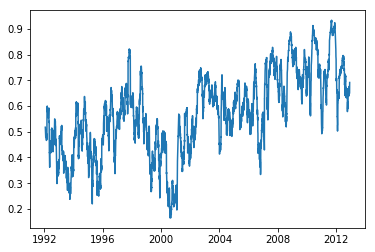

In [30]:
## Now get 1d Time Series

 # We look at the mean correlation value like Stepanov et al. and try to fit a time series to this.

c_bar = CorrMatrices.mean(axis=1)
plt.plot(T,c_bar)
plt.show()
TimeSeries = pd.DataFrame(data = {"t": T,
                                "c_bar": c_bar})
TimeSeries.to_csv("TimeSeries_Finance_Reduced")

In [31]:
print(len(T), len(Labels))

5251 5251


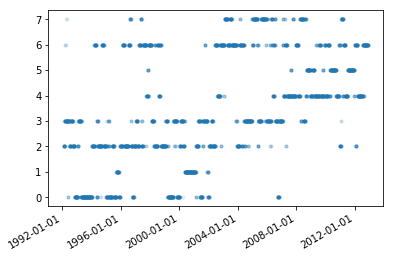

In [32]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Labels, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [33]:
np.array(np.unique(Labels, return_counts=True)).T

array([[  0, 660],
       [  1, 247],
       [  2, 939],
       [  3, 893],
       [  4, 759],
       [  5, 338],
       [  6, 994],
       [  7, 421]])

In [34]:
# Combine all Centroids to one array

Centroids = np.concatenate((kmean00.cluster_centers_,
                            kmean01.cluster_centers_,
                            kmean10.cluster_centers_,
                           kmean11.cluster_centers_))
print(Centroids.shape)
print(Centroids[0].shape)

(8, 55)
(55,)


### Compare this to a true kmeans-approach

And try to sort the labels according to their emergence in data.

In [35]:
KMTrue = KMeans(n_clusters = 8,random_state = 12345).fit(CorrMatrices) 

In [36]:
KMTrue.predict(CorrMatrices)

array([7, 7, 4, ..., 6, 6, 2], dtype=int32)

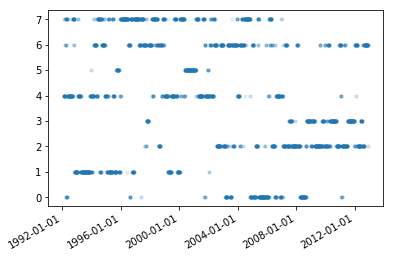

In [37]:
LabelNaive = KMTrue.predict(CorrMatrices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaive, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [38]:
Indexshift = np.zeros(((max(LabelNaive)+1),2)).astype("int") # keep track of which cluster is assigned which number

Indexshift = pd.DataFrame({"Old Label":[],
                          "New Label":[]})
NewLabel = int(0)
for i in range(len(LabelNaive)):
    if (LabelNaive[i] in set(Indexshift["Old Label"]))==False:
        Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],
                                                      "New Label":[NewLabel]}), ignore_index=True)
        NewLabel = int(NewLabel+1)
print(Indexshift)

   Old Label  New Label
0        7.0        0.0
1        4.0        1.0
2        6.0        2.0
3        0.0        3.0
4        1.0        4.0
5        5.0        5.0
6        2.0        6.0
7        3.0        7.0


In [39]:
LabelNaiveOrdered = np.empty(len(LabelNaive))

for i in range(len(LabelNaive)):
    LabelNaiveOrdered[i] = int(Indexshift.loc[Indexshift["Old Label"]==LabelNaive[i]]["New Label"])

CentroidsNaive = np.zeros((max(LabelNaive)+1, CorrMatrices.shape[1]))

for j in range(max(LabelNaive)+1): # go through the new orering of the clusters
    Old_Order = int(Indexshift.loc[Indexshift["New Label"]==j]["Old Label"])
    CentroidsNaive[j] = KMTrue.cluster_centers_[Old_Order]

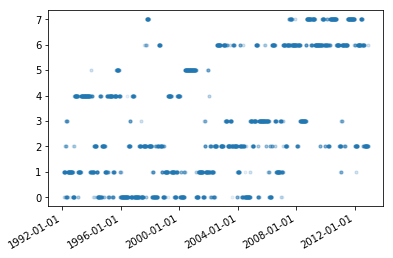

In [40]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaiveOrdered,
         ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [41]:
Indexshift["Old Label"][0]

7.0

In [42]:
for i in range(CentroidsNaive.shape[0]):
    print(sum(KMTrue.cluster_centers_[int(Indexshift["Old Label"][i])]  != CentroidsNaive[i]  ))
#print(KMTrue.cluster_centers_[6])

0
0
0
0
0
0
0
0


## Neuralising kmeans

In [43]:
(Centroids**2.).sum(1) - (Centroids[4]**2.).sum()

array([-23.19078028, -25.57591915, -16.22871323, -15.38298294,
         0.        ,   9.49747214,  -8.2859117 ,  -6.46530825])

In [44]:
w_4 = 2*(Centroids[4] - Centroids)
print(w_4.dot(CorrMatrices.T))

[[21.41348808 21.36446845 20.76377916 ... 28.80055146 28.77994094
  29.58112202]
 [27.16301913 27.09431674 26.36310973 ... 35.97863514 35.9612708
  36.96339074]
 [13.03037341 13.00579726 12.64528809 ... 17.53911962 17.54388749
  18.05879986]
 ...
 [-5.79533461 -5.78239729 -5.64599709 ... -7.80380799 -7.80184419
  -8.03608658]
 [ 5.86565442  5.85546098  5.70251665 ...  7.97727784  7.98256754
   8.22794305]
 [ 4.96613266  4.95907071  4.81427215 ...  7.457404    7.46072619
   7.66851803]]


In [45]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [46]:
print("First instances Label is", Labels[0])

First instances Label is 2


In [47]:
k = 1451 # some instance

print("Should only be True for Label", Labels[k])

print(" # # # # # #")
for i in range(max(Labels)+1):
    print(i,DecisionLayer(NN_k(CorrMatrices[k,:],Centroids, i)))
    print("# # # # # ")
    
    

Should only be True for Label 4
 # # # # # #
0 False
# # # # # 
1 False
# # # # # 
2 False
# # # # # 
3 False
# # # # # 
4 True
# # # # # 
5 False
# # # # # 
6 False
# # # # # 
7 False
# # # # # 


In [48]:
layer2(layer1(CorrMatrices[0,:],Centroids,1),1)

-4.785439795806903

In [49]:
nKM = max(Labels) + 1 # number of clusters


# CHeck for all instances
Layer_Pred = np.empty(CorrMatrices.shape[0])
Layer_1 = np.empty((CorrMatrices.shape[0], nKM))
Layer_2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],Centroids, j))    
        if Decision:
            Layer_Pred[i] = range(nKM)[j]
            Layer_1[i,:] = layer1(CorrMatrices[i,:], Centroids, j)
            Layer_2[i] = layer2(Layer_1[i,:], j)
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, Labels[i], Layer_Pred[i])
print(sum(Layer_Pred != Labels))


273


In [50]:
print(np.mean(Layer_2))
print(np.mean(Layer_2[Layer_Pred == Labels]))
print(np.mean(Layer_2[Layer_Pred != Labels]))

0.5360955333244632
0.558324027347879
0.13077156538100637


In [51]:
# Do it again for the naive kmeans




# CHeck for all instances
Layer_Pred2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred2)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],KMTrue.cluster_centers_, j))    
        if Decision:
            Layer_Pred2[i] = range(nKM)[j]
            
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, LabelNaive[i], Layer_Pred2[i])
print(sum(Layer_Pred2 != LabelNaive))
# So this actually works!!!

0


## Analyse what went wrong

Apparently, the neuralisation does not work this way for the bipartite-split kmeans. However, the "regular" kmeans seems to be qualitatively similar, so we might as well continue with that.

In [52]:
WrongL1 = Layer_1[Layer_Pred != Labels].round(1)

Wrong = pd.DataFrame({"Label": Labels[Layer_Pred != Labels],
                     "Predict": Layer_Pred[Layer_Pred != Labels].astype("int")})

for i in range(WrongL1.shape[1]):
    Name = "Cluster "+ str(i)
    Wrong[Name] = WrongL1[:,i]

print(Wrong.iloc[0:50])

    Label  Predict  Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  \
0       3        6        2.5        6.7        0.1        0.1        1.6   
1       7        3        2.7        7.3        0.2        0.0        1.7   
2       2        0        0.0        2.6        0.0        0.0        6.0   
3       0        2        0.1        3.0        0.0        1.5        6.2   
4       3        0        0.0        2.5        0.5        0.0        6.3   
5       3        0        0.0        2.7        0.6        0.2        6.2   
6       3        0        0.0        2.8        0.4        0.2        5.8   
7       3        0        0.0        2.8        0.5        0.2        6.0   
8       3        0        0.0        2.8        0.5        0.2        6.2   
9       3        0        0.0        2.7        0.7        0.4        6.6   
10      3        0        0.0        3.0        0.5        0.4        6.1   
11      3        0        0.0        3.2        0.6        0.6        6.2   

In [53]:
print(Layer_1[Layer_Pred != Labels].round(2).shape)
print(np.mean(Layer_1[Layer_Pred != Labels].max(1).round(2)))

print(Layer_1[Layer_Pred == Labels].round(2))
print(np.mean(Layer_1[Layer_Pred == Labels].max(1).round(2)))

(273, 8)
10.19827838827839
[[ 1.42  4.79  0.   ...  6.9   0.78  1.7 ]
 [ 1.4   4.74  0.   ...  6.94  0.79  1.72]
 [ 1.16  4.37  0.   ...  7.43  1.    1.93]
 ...
 [ 5.92 10.71  1.62 ...  2.    0.    1.3 ]
 [ 5.89 10.69  1.62 ...  2.    0.    1.3 ]
 [ 6.45 11.45  1.89 ...  1.52  0.    1.26]]
11.509895540377661


#### Problem:

Neuralisation does not always yield the same results as the original clustering. The error quote is about 5%. The reason behind this (see above block) might be that the wrong labels have an output of layer2 that is close to zero, i.e. their classification  not as "clear-cut" 

In [54]:
np.mean(Layer_Pred!=Labels)

0.05199009712435727

In [55]:
Labels[Layer_Pred != Labels] 

array([3, 7, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2,
       2, 3, 3, 3, 2, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 6, 6, 6, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 2, 2, 2, 2, 2, 7, 7, 7, 7,
       7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6,
       6, 0, 0, 0, 0, 0, 0, 0, 3, 6, 6, 6, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 2, 4, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6])

In [56]:
Layer_Pred[Layer_Pred != Labels]

array([6., 3., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 6., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 6., 7.,
       0., 0., 6., 7., 2., 2., 2., 2., 4., 4., 4., 4., 4., 6., 6., 0., 0.,
       0., 0., 0., 3., 0., 2., 2., 2., 0., 2., 2., 2., 2., 2., 0., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 3., 3., 3.,
       3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 6., 6., 4., 4., 4., 4., 4., 6., 6., 6., 6., 6., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 0., 0., 0., 0., 4., 4., 4.,
       4., 4., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 7., 4., 4.,
       4., 6., 6., 6., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       4., 4., 4., 4., 4.

### LRP Functions

In [57]:
def beta(X, i, DecisionL, NN, Centroids):
    # Takes the Data X, a particular class i, a Decision Layer DecisionL and Neuralised kmeans NN = NN(x,centroids,k)
    # Returns the beta-scaling factor from eq. (3)
    IS_i = np.empty(X.shape[0])
    
    for j in range(X.shape[0]):
        IS_i[j] = NN(X[j,:],
                     Centroids,
                     i)
    return( np.mean(IS_i)**(-1.))
    

In [58]:


def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

In [59]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_InputLayer)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [60]:

def xai_clust(X, Centroids, X_Label, Dat, DecisionL, Neuralised):

    return(Eq4(X, Centroids,  X_Label,
           beta(Dat, X_Label, DecisionL, Neuralised, Centroids)))


In [61]:
xai_clust(CorrMatrices[0,:], 
          CentroidsNaive, 0, CorrMatrices, 
          DecisionLayer, NN_k).round(1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

## Go through entire Data

In [62]:
XAI = np.zeros(CorrMatrices.shape)
LabelNaiveOrdered # is the ordered label output

for i in range(CorrMatrices.shape[0]):
    x = CorrMatrices[i,:]
    XAI[i,:] = xai_clust(x, CentroidsNaive, 
                         LabelNaiveOrdered.astype("int")[i],
                         CorrMatrices, DecisionLayer, NN_k)
print(XAI.round(1))

[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [-0.  -0.1 -0.  ...  0.   0.1  0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.1  0.  ...  0.   0.   0. ]]


In [63]:
for i in range(XAI.shape[1]):
    print(i,np.mean(XAI[:,i]).round(1))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0


Cluster 0 with centroid [0.38 0.4  0.48 0.35 0.39 0.26 0.36 0.47 0.29 0.42 0.71 0.76 0.49 0.64
 0.48 0.6  0.66 0.51 0.68 0.78 0.57 0.7  0.48 0.64 0.66 0.47 0.72 0.54
 0.7  0.5  0.66 0.77 0.57 0.73 0.56 0.39 0.47 0.51 0.26 0.49 0.41 0.57
 0.63 0.39 0.68 0.37 0.45 0.27 0.43 0.55 0.52 0.61 0.44 0.62 0.55]
And mean importances [0.03 0.03 0.03 0.02 0.02 0.03 0.04 0.02 0.04 0.03 0.01 0.01 0.02 0.02
 0.01 0.01 0.01 0.02 0.01 0.   0.02 0.02 0.02 0.01 0.01 0.02 0.01 0.02
 0.02 0.01 0.01 0.   0.02 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.01 0.03 0.01 0.02 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.02]


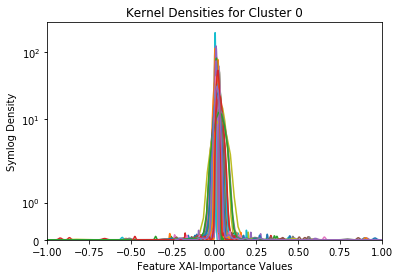

Cluster 1 with centroid [0.18 0.2  0.29 0.24 0.16 0.11 0.22 0.32 0.25 0.25 0.69 0.74 0.26 0.59
 0.43 0.56 0.57 0.65 0.64 0.73 0.39 0.6  0.43 0.59 0.56 0.62 0.65 0.31
 0.56 0.44 0.57 0.73 0.69 0.65 0.41 0.21 0.3  0.26 0.25 0.28 0.3  0.48
 0.48 0.46 0.6  0.33 0.39 0.37 0.38 0.45 0.57 0.51 0.52 0.52 0.61]
And mean importances [0.04 0.03 0.03 0.03 0.04 0.04 0.04 0.03 0.03 0.03 0.   0.   0.03 0.01
 0.02 0.01 0.01 0.01 0.01 0.   0.02 0.01 0.02 0.01 0.01 0.01 0.01 0.03
 0.01 0.02 0.01 0.   0.01 0.01 0.02 0.03 0.02 0.03 0.03 0.03 0.02 0.02
 0.02 0.02 0.01 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.02 0.01]


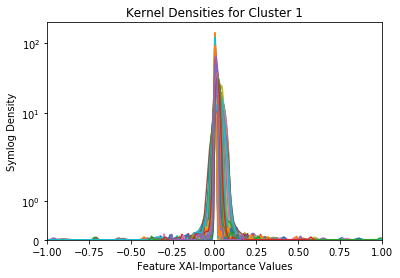

Cluster 2 with centroid [0.53 0.59 0.62 0.45 0.5  0.41 0.54 0.62 0.51 0.57 0.77 0.83 0.47 0.66
 0.56 0.67 0.74 0.69 0.71 0.82 0.53 0.68 0.58 0.72 0.75 0.7  0.76 0.51
 0.69 0.57 0.72 0.84 0.77 0.79 0.54 0.4  0.52 0.49 0.4  0.49 0.43 0.61
 0.65 0.56 0.69 0.48 0.55 0.47 0.51 0.66 0.66 0.69 0.67 0.71 0.71]
And mean importances [0.03 0.04 0.03 0.01 0.02 0.02 0.04 0.03 0.04 0.02 0.01 0.   0.03 0.03
 0.01 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.02
 0.02 0.01 0.01 0.   0.01 0.02 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.02 0.04 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.03 0.03 0.02]


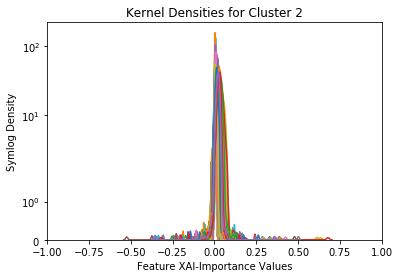

Cluster 3 with centroid [0.21 0.21 0.32 0.43 0.18 0.26 0.22 0.43 0.23 0.26 0.79 0.84 0.53 0.75
 0.64 0.7  0.72 0.75 0.76 0.81 0.57 0.76 0.68 0.73 0.71 0.73 0.76 0.6
 0.78 0.65 0.73 0.83 0.8  0.81 0.59 0.56 0.53 0.55 0.5  0.58 0.59 0.7
 0.65 0.68 0.77 0.56 0.61 0.61 0.64 0.62 0.73 0.7  0.69 0.71 0.75]
And mean importances [0.02 0.03 0.02 0.01 0.02 0.02 0.03 0.02 0.03 0.02 0.01 0.   0.03 0.03
 0.01 0.01 0.01 0.02 0.02 0.   0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.03
 0.03 0.01 0.01 0.   0.01 0.02 0.01 0.03 0.03 0.02 0.03 0.02 0.02 0.03
 0.02 0.04 0.02 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.03 0.03 0.02]


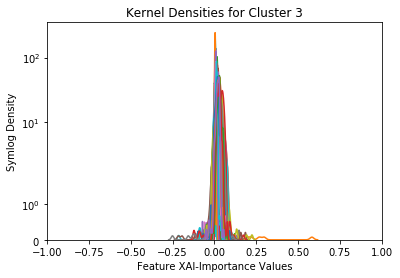

Cluster 4 with centroid [0.28 0.28 0.38 0.21 0.24 0.17 0.11 0.33 0.16 0.25 0.56 0.55 0.32 0.54
 0.27 0.41 0.39 0.45 0.45 0.57 0.51 0.53 0.3  0.43 0.41 0.4  0.46 0.4
 0.47 0.32 0.36 0.64 0.44 0.37 0.44 0.22 0.33 0.34 0.19 0.22 0.21 0.45
 0.37 0.38 0.56 0.13 0.3  0.14 0.22 0.26 0.36 0.35 0.31 0.26 0.46]
And mean importances [0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.02 0.03 0.02 0.01 0.01 0.01 0.01
 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.01
 0.01 0.02 0.02 0.01 0.02 0.03 0.01 0.02 0.02 0.01 0.02 0.02 0.02 0.01
 0.02 0.02 0.01 0.03 0.02 0.03 0.02 0.03 0.02 0.02 0.03 0.04 0.01]


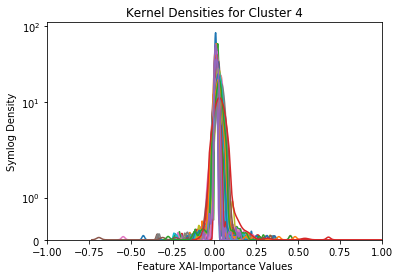

Cluster 5 with centroid [ 0.05  0.05  0.09  0.26  0.17  0.07  0.01  0.17 -0.04  0.15  0.55  0.69
 -0.01  0.16  0.4   0.42  0.56  0.3   0.35  0.62  0.15  0.24  0.45  0.42
  0.44  0.3   0.43  0.06  0.22  0.44  0.47  0.69  0.45  0.45  0.39  0.07
 -0.01  0.06 -0.06  0.11  0.11  0.15  0.26 -0.02  0.3   0.29  0.38  0.15
  0.28  0.35  0.36  0.24  0.15  0.23  0.28]
And mean importances [0.02 0.02 0.03 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.01 0.   0.03 0.04
 0.01 0.01 0.01 0.02 0.02 0.   0.02 0.03 0.01 0.01 0.01 0.01 0.01 0.03
 0.03 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.03 0.03 0.03 0.02 0.02 0.03
 0.02 0.05 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.02 0.02 0.02]


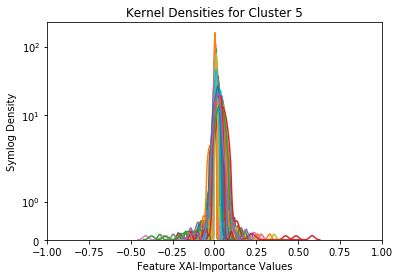

Cluster 6 with centroid [0.62 0.65 0.74 0.62 0.59 0.57 0.66 0.77 0.68 0.65 0.79 0.86 0.61 0.73
 0.69 0.75 0.8  0.79 0.75 0.84 0.65 0.72 0.75 0.78 0.8  0.78 0.78 0.67
 0.76 0.73 0.82 0.9  0.87 0.83 0.69 0.59 0.65 0.65 0.61 0.68 0.62 0.73
 0.73 0.69 0.79 0.64 0.7  0.64 0.65 0.77 0.8  0.77 0.81 0.78 0.78]
And mean importances [0.03 0.03 0.03 0.01 0.02 0.02 0.03 0.03 0.04 0.02 0.   0.   0.03 0.02
 0.01 0.01 0.01 0.02 0.01 0.   0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.03
 0.02 0.01 0.01 0.   0.02 0.01 0.01 0.02 0.03 0.03 0.03 0.03 0.02 0.02
 0.02 0.03 0.02 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.03 0.02 0.02]


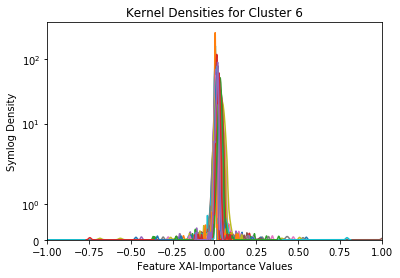

Cluster 7 with centroid [0.81 0.82 0.87 0.79 0.78 0.76 0.83 0.89 0.84 0.83 0.87 0.92 0.75 0.83
 0.84 0.87 0.9  0.89 0.86 0.9  0.76 0.8  0.87 0.86 0.88 0.87 0.86 0.78
 0.84 0.84 0.89 0.95 0.93 0.9  0.82 0.7  0.8  0.77 0.75 0.79 0.75 0.84
 0.83 0.81 0.86 0.79 0.83 0.81 0.79 0.87 0.88 0.87 0.9  0.88 0.87]
And mean importances [0.03 0.03 0.03 0.02 0.03 0.03 0.04 0.03 0.04 0.03 0.01 0.   0.02 0.02
 0.02 0.01 0.01 0.02 0.01 0.   0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.02
 0.01 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.01 0.03 0.01 0.02 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.02]


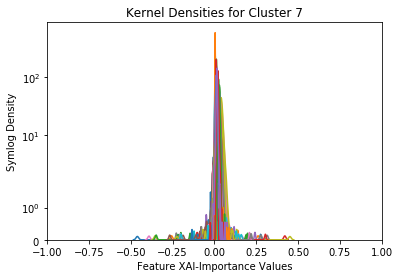

In [64]:
import warnings
warnings.filterwarnings("ignore")

for i in range(nKM):
    print("Cluster", i, "with centroid", CentroidsNaive[i].round(2))
    print("And mean importances", XAI[LabelNaiveOrdered==i,:].mean(0).round(2))
    plt.yscale("symlog", linthresh=1)

    for j in range(min(CorrMatrices.shape[1],100)):
        sns.kdeplot(XAI[LabelNaiveOrdered==i,j], label="Feature " +str(j))
    plt.xlim([-1, 1])
    plt.title("Kernel Densities for Cluster "+str(i))
    plt.ylabel("Symlog Density")
    plt.xlabel("Feature XAI-Importance Values")
    #plt.legend()
    plt.show()

In [65]:
for i in range(nKM):
    print(max(XAI[Labels==i,:].mean(0)))

0.03495643899588395
0.046584363030388314
0.03414311432829372
0.041860246161340584
0.04200963129492137
0.03999589169341221
0.037686527487998334
0.039551121994061515


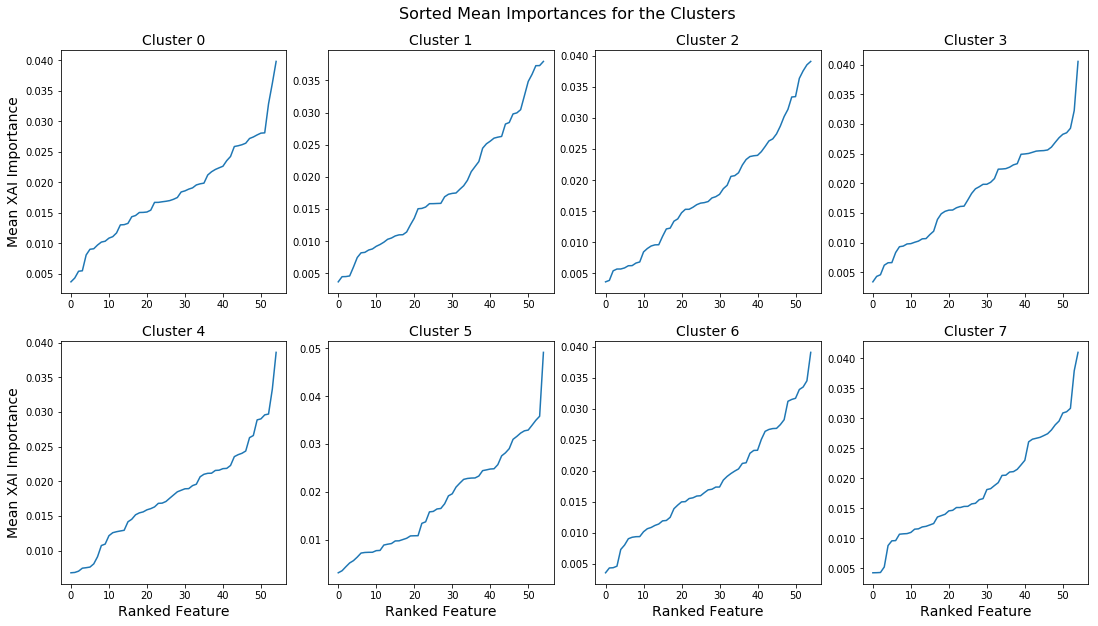

In [66]:
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle("Sorted Mean Importances for the Clusters", fontsize = 16,y=1.05)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

axs[0,0].set_ylabel("Mean XAI Importance", fontsize=14)
axs[1,0].set_ylabel("Mean XAI Importance", fontsize=14)

for i in range(4):
    axs[0,i].set_title("Cluster "+ str(i), fontsize=14)
    axs[0,i].plot(np.sort(XAI[LabelNaiveOrdered==i,:].mean(0)))
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)

for i in range(4):
    axs[1,i].set_title("Cluster "+ str(i+4), fontsize=14)
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)
    axs[1,i].plot(np.sort(XAI[LabelNaiveOrdered==i+4,:].mean(0)))
plt.show()    

At least for some clusters, one can clearly see an elbow-curve-behaviour at the left and/or right extremes of the feature ranking.

## Now aggregated across all clusters

Text(0.5, 0, 'Sorted Features')

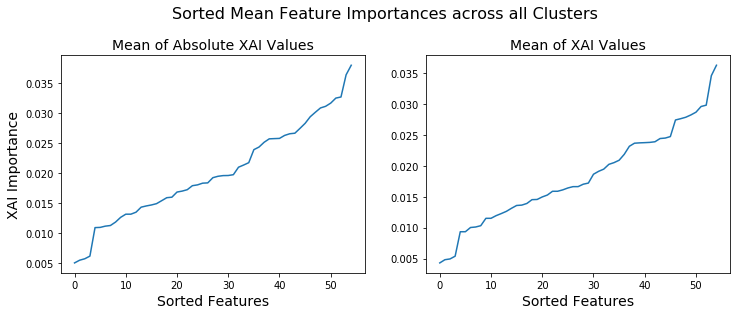

In [67]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)


These are some interesting plots and also show elbow curves for the means. The means of absolute values are less clear to interpret as a sigmoid/elbos

## Export some Plots

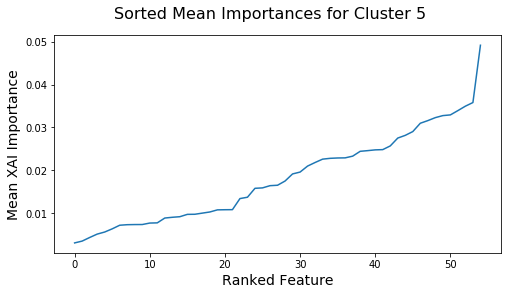

In [68]:
j = 5

fig, axs = plt.subplots(1, 1,figsize=(8,4))
fig.suptitle("Sorted Mean Importances for Cluster "+str(j), fontsize = 16)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.2)

#axs,set_title("Sorted Mean Importances for Cluster 2")
axs.set_ylabel("Mean XAI Importance", fontsize=14)
axs.plot(np.sort(XAI[LabelNaiveOrdered==j,:].mean(0)))
axs.set_xlabel('Ranked Feature', fontsize=14)
fig.savefig("XAI_Cluster"+str(j)+".png",  dpi=800)

In [69]:
# Export the corresponding data
np.save("XAI_Data_Cluster5.npy",
        XAI[LabelNaiveOrdered==j,:].mean(0))

## Detecting the Elbow

Use a linear interpolation before the elbow or at the centre of the curve. Then, assume that the elbow is at the consecutively n last ranked instances for which the XAI-value is above 3*sigma + linear regression.

In [70]:

def DetectElbow(Data, lower, upper, Deviation = 3, plot = False):
    # Input: Data and a lower/upper index for the range to use for linear interpolation
    # output: The index I for which all Data[-i:-1] are clearly above the linear regression
    #         i.e. the elbow starts at Data[-i]
    #         and all Features which are deemed relevant
    
    Index = np.argsort(Data)
    Sorted = np.sort(Data)
    LR = linregress(np.arange(lower, upper),
                   Sorted[lower:upper])
    
    residua = Sorted - (LR.intercept + LR.slope * np.arange(len(Data)))
    
    Output = None
    RelevantIndex = None
    if residua[-1] > Deviation* LR.stderr:
        Check = True
        i = 1
        while Check:
            i+=1
            Check = (residua[len(residua)-i] > Deviation*LR.stderr)
        Output = i
        RelevantIndex = Index[len(Index)-i+1:] # last i Index values, i,e. highest values
    
    if plot:
            plt.plot(Sorted)
            plt.plot(LR.intercept + LR.slope * np.arange(len(Data)))
            plt.axvline(len(residua)-i,
                       c="red")
            plt.show()
    
    return([Output-1, RelevantIndex])

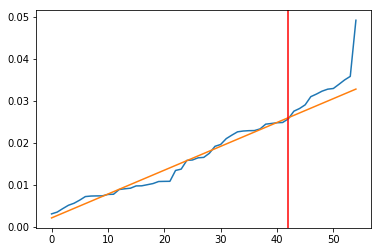

[12, array([ 2, 28, 21,  6, 37, 27, 36,  8, 12, 38, 13, 43])]

In [71]:
DetectElbow(XAI[LabelNaiveOrdered==5,:].mean(0), 0, 45, 3, True)

In [72]:
AllRelevant = np.array([])

for j in range(nKM):
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, False)
    print(j, DE)
    AllRelevant=np.concatenate([AllRelevant,DE[1]])
print(AllRelevant)

0 [3, array([47,  6,  8])]
1 [9, array([ 9, 37,  2,  8,  1,  0,  4,  6,  5])]
2 [8, array([ 0, 36, 52,  2,  1,  6, 43,  8])]
3 [2, array([38, 43])]
4 [6, array([33, 45,  6,  8, 47, 53])]
5 [9, array([ 6, 37, 27, 36,  8, 12, 38, 13, 43])]
6 [7, array([ 2, 36, 43, 38, 52,  6,  8])]
7 [7, array([ 5,  2, 38,  1,  0,  6,  8])]
[47.  6.  8.  9. 37.  2.  8.  1.  0.  4.  6.  5.  0. 36. 52.  2.  1.  6.
 43.  8. 38. 43. 33. 45.  6.  8. 47. 53.  6. 37. 27. 36.  8. 12. 38. 13.
 43.  2. 36. 43. 38. 52.  6.  8.  5.  2. 38.  1.  0.  6.  8.]


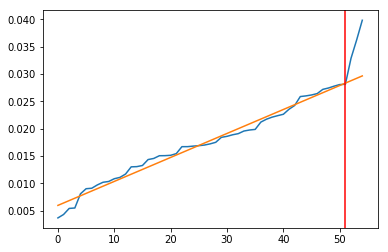

0 3 [47  6  8]


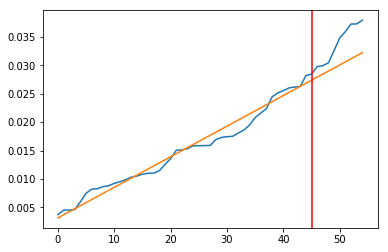

1 9 [ 9 37  2  8  1  0  4  6  5]


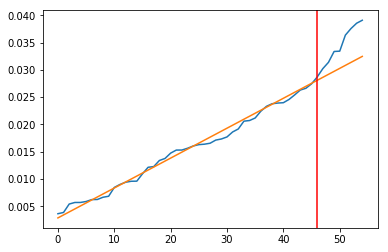

2 8 [ 0 36 52  2  1  6 43  8]


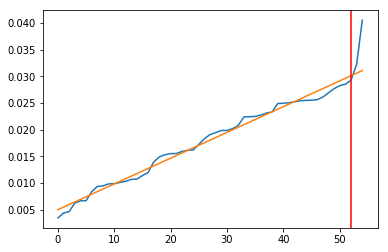

3 2 [38 43]


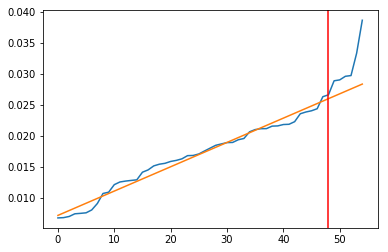

4 6 [33 45  6  8 47 53]


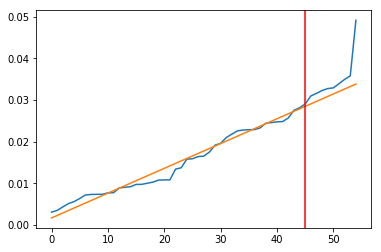

5 9 [ 6 37 27 36  8 12 38 13 43]


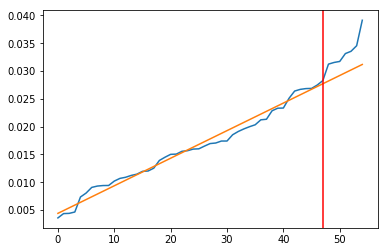

6 7 [ 2 36 43 38 52  6  8]


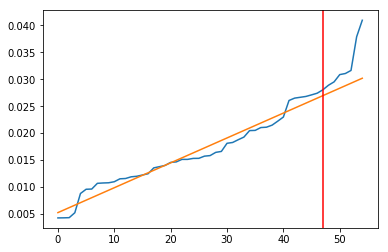

7 7 [ 5  2 38  1  0  6  8]


In [73]:
# and with plots
for j in range(nKM):
    #DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    print(j, DE[0], DE[1] )

In [74]:
np.array(np.unique(AllRelevant, return_counts=True)).T

array([[ 0.,  3.],
       [ 1.,  3.],
       [ 2.,  4.],
       [ 4.,  1.],
       [ 5.,  2.],
       [ 6.,  7.],
       [ 8.,  7.],
       [ 9.,  1.],
       [12.,  1.],
       [13.,  1.],
       [27.,  1.],
       [33.,  1.],
       [36.,  3.],
       [37.,  2.],
       [38.,  4.],
       [43.,  4.],
       [45.,  1.],
       [47.,  2.],
       [52.,  2.],
       [53.,  1.]])

(array([3., 3., 4., 0., 1., 2., 7., 0., 7., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 3., 2., 4., 0., 0., 0., 0., 4., 0., 1., 0., 2., 0., 0., 0.,
        0., 2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5]),
 <a list of 53 Patch objects>)

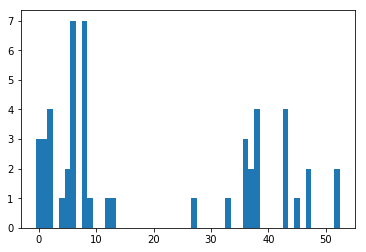

In [75]:
plt.hist(AllRelevant, bins = np.arange(-0.5,
                                       max(AllRelevant)+0.5,1))

### Transform back to original sectors

In [160]:
def ReverseDiag(Array, ZERO = False):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)
    
    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)
    
    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)
    
    Original[index] = Array # upper triangle
    Original = Original.reshape((11,11))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((11,11))

    return(Original)

In [161]:
ReverseDiag(CorrMatrices[1,:])== CorrMatricesFull[1,:].reshape((11,11))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

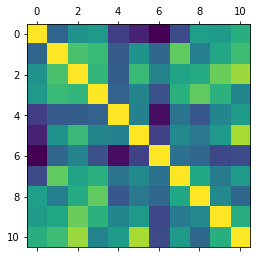

In [162]:
plt.matshow(ReverseDiag(CorrMatrices[1,:]))

In [163]:
print(DF.columns)
Names = ["E", "CD", "F", "I", "U", "CS", "RE", "Com", "M", "IT", "HC"]

Index(['Energy', 'Consumer Discretionary', 'Financials', 'Industrials',
       'Utilities', 'Consumer Staples', 'Real Estate',
       'Communication Services', 'Materials', 'Information Technology',
       'Health Care'],
      dtype='object')


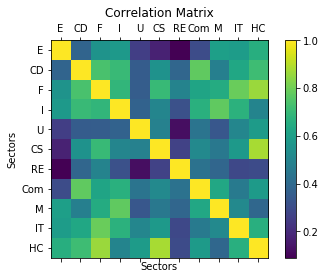

In [164]:
def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()
    
plot_matrix(ReverseDiag(CorrMatrices[1,:]),
           labels = Names)

### Plot Relevances

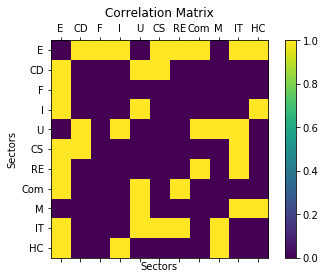

In [169]:
RelevantCombined = np.array(list(set(AllRelevant))).astype("int")
RelevancePlot = np.zeros(55)
RelevancePlot[RelevantCombined] = 1.
plot_matrix(ReverseDiag(RelevancePlot,
                       ZERO = True),
           labels = Names)